In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import gpytorch

In [2]:
def error_prop(function, x, xerrl, xerrh):

    value = function(x)
    value_errl = value - function(x-xerrl)
    value_errh = function(x+xerrh) - value
    value_err = function(x+xerrh) - function(x-xerrl)

    return value, value_errl, value_errh, value_err

def cont_to_weaver(x):
    return (10**x)*1000

def weaver_to_cont(x):
    return np.log10(x/1000)

In [3]:
def get_phi1_data(plotting=False):

    weaver_low_mass_norm_val = np.array([0.73, 0.66, 0.84, 0.72, 0.29, 0.27, 0.24, 0.21, 0.20, 0.14, 0.06, 0.03])
    weaver_low_mass_norm_errl = np.array([0.27, 0.27, 0.31, 0.23, 0.11, 0.08, 0.02, 0.03, 0.03, 0.03, 0.02, 0.02])
    weaver_low_mass_norm_errh = np.array([0.25, 0.22, 0.20, 0.15, 0.11, 0.09, 0.03, 0.03, 0.03, 0.04, 0.03, 0.03])
    weaver_redshift_lower_bin_edge = np.array([0.2, 0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5])
    weaver_redshift_upper_bin_edge = np.array([0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5, 7.5])
    weaver_redshift_midpoint = (weaver_redshift_lower_bin_edge + weaver_redshift_upper_bin_edge)/2

    log_cont_low_mass_norm_val = np.array([-2.89, -3.29, -3.51])
    cont_low_mass_norm_log_errl = np.array([0.04, 0.03, 0.03])
    cont_low_mass_norm_log_errh = np.array([0.03, 0.03, 0.03])
    cont_redshift_anchor_points = np.array([0.2, 1.6, 3.0])

    cont_low_mass_norm_val, cont_low_mass_norm_errl, cont_low_mass_norm_errh, cont_low_mass_norm_errs = error_prop(cont_to_weaver, log_cont_low_mass_norm_val, cont_low_mass_norm_log_errl, cont_low_mass_norm_log_errh)

    zg3_index = np.where(weaver_redshift_midpoint>3.0)[0]
    zg3_redshifts = weaver_redshift_midpoint[zg3_index]
    highz_low_mass_norm_val = weaver_low_mass_norm_val[zg3_index]
    highz_low_mass_norm_errl = weaver_low_mass_norm_val[zg3_index]
    high_zlow_mass_norm_errh = (cont_low_mass_norm_errh[-1] + cont_low_mass_norm_val[-1] - weaver_low_mass_norm_val[zg3_index])


    train_phi1 = torch.from_numpy(np.concatenate((weaver_low_mass_norm_val, cont_low_mass_norm_val)))
    train_phi1_errl = torch.from_numpy(np.concatenate((weaver_low_mass_norm_errl, cont_low_mass_norm_errl)))
    train_phi1_errh = torch.from_numpy(np.concatenate((weaver_low_mass_norm_errh, cont_low_mass_norm_errh)))
    train_phi1_errs = train_phi1_errl + train_phi1_errh
    train_redshift = torch.from_numpy(np.concatenate((weaver_redshift_midpoint, cont_redshift_anchor_points)))

    sorted_redshift_inds = train_redshift.argsort()[:]
    sorted_train_phi1 = train_phi1[sorted_redshift_inds]
    sorted_train_phi1_errl = train_phi1_errl[sorted_redshift_inds]
    sorted_train_phi1_errh = train_phi1_errh[sorted_redshift_inds]
    sorted_train_phi1_errs = sorted_train_phi1_errl + sorted_train_phi1_errh
    sorted_train_redshift = train_redshift[sorted_redshift_inds]

    sorted_train_logphi1, sorted_train_logphi1_errl, sorted_train_logphi1_errh, sorted_train_logphi1_errs = error_prop(weaver_to_cont, sorted_train_phi1, sorted_train_phi1_errl, sorted_train_phi1_errh)

    if(plotting):
        plt.errorbar(weaver_redshift_midpoint, weaver_low_mass_norm_val, yerr=[weaver_low_mass_norm_errl, weaver_low_mass_norm_errh], fmt='ko')


        plt.errorbar(cont_redshift_anchor_points, cont_low_mass_norm_val, yerr=[cont_low_mass_norm_errl, cont_low_mass_norm_errh])

        plt.errorbar(zg3_redshifts, highz_low_mass_norm_val, yerr=[highz_low_mass_norm_errl, high_zlow_mass_norm_errh], fmt='ro')
        plt.ylabel("Low Mass Normalisation $\phi_{1} 10^{-3}\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}$")
        plt.xlabel("redshift")

        flogphi, ax1 = plt.subplots(1, 1, figsize=(10, 7))
        ax1.errorbar(sorted_train_redshift, sorted_train_logphi1, yerr=[sorted_train_logphi1_errl, sorted_train_logphi1_errh], fmt='ko')
        ax1.set_ylabel("Low Mass Normalisation $log_{10}(\phi_{1})$")
        ax1.set_xlabel("redshift")
    
    return sorted_train_redshift, sorted_train_logphi1, sorted_train_logphi1_errl, sorted_train_logphi1_errh, sorted_train_logphi1_errs

def get_phi2_data(plotting=False):

    weaver_high_mass_norm_val = np.array([1.09, 0.83, 0.66, 0.34, 0.64, 0.27])
    weaver_high_mass_norm_errl = np.array([0.54, 0.43, 0.42, 0.25, 0.16, 0.12])
    weaver_high_mass_norm_errh = np.array([0.5, 0.37, 0.34, 0.30, 0.13, 0.12])
    weaver_redshift_lower_bin_edge_lowz = np.array([0.2, 0.5, 0.8, 1.1, 1.5, 2.0])
    weaver_redshift_upper_bin_edge_lowz = np.array([0.5, 0.8, 1.1, 1.5, 2.0, 2.5])
    weaver_redshift_midpoint_lowz = (weaver_redshift_lower_bin_edge_lowz + weaver_redshift_upper_bin_edge_lowz)/2

    log_cont_high_mass_norm_val = np.array([-2.44, -3.08, -4.14])
    cont_high_mass_norm_val = (10**log_cont_high_mass_norm_val)*1000
    cont_high_mass_norm_log_errl = np.array([0.02, 0.03, 0.11])
    cont_high_mass_norm_log_errh = np.array([0.02, 0.02, 0.10])
    cont_high_mass_norm_errl = cont_high_mass_norm_val - (10**(log_cont_high_mass_norm_val - cont_high_mass_norm_log_errl))*1000
    cont_high_mass_norm_errh = (10**(log_cont_high_mass_norm_val + cont_high_mass_norm_log_errh))*1000 - cont_high_mass_norm_val
    cont_redshift_anchor_points = np.array([0.2, 1.6, 3.0])

    train_phi2 = torch.from_numpy(np.concatenate((weaver_high_mass_norm_val, cont_high_mass_norm_val)))
    train_phi2_errl = torch.from_numpy(np.concatenate((weaver_high_mass_norm_errl, cont_high_mass_norm_errl)))
    train_phi2_errh = torch.from_numpy(np.concatenate((weaver_high_mass_norm_errh, cont_high_mass_norm_errh)))
    train_phi2_errs = train_phi2_errl + train_phi2_errh
    train_redshift = torch.from_numpy(np.concatenate((weaver_redshift_midpoint_lowz, cont_redshift_anchor_points)))

    sorted_redshift_inds = train_redshift.argsort()[:]
    sorted_train_phi2 = train_phi2[sorted_redshift_inds]
    sorted_train_phi2_errl = train_phi2_errl[sorted_redshift_inds]
    sorted_train_phi2_errh = train_phi2_errh[sorted_redshift_inds]
    sorted_train_phi2_errs = sorted_train_phi2_errl + sorted_train_phi2_errh
    sorted_train_redshift = train_redshift[sorted_redshift_inds]

    sorted_train_logphi2, sorted_train_logphi2_errl, sorted_train_logphi2_errh, sorted_train_logphi2_errs = error_prop(weaver_to_cont, sorted_train_phi2, sorted_train_phi2_errl, sorted_train_phi2_errh)

    if(plotting):
        plt.errorbar(weaver_redshift_midpoint_lowz, weaver_high_mass_norm_val, yerr=[weaver_high_mass_norm_errl, weaver_high_mass_norm_errh], fmt='ko')

        plt.errorbar(cont_redshift_anchor_points, cont_high_mass_norm_val, yerr=[cont_high_mass_norm_errl, cont_high_mass_norm_errh])
        plt.ylabel("High Mass Normalisation $\phi_{2} 10^{-3}\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}$")
        plt.xlabel("redshift")
        plt.xlim(-0.2, 7.2)

        flogphi, ax2 = plt.subplots(1, 1, figsize=(10, 7))
        ax2.errorbar(sorted_train_redshift, sorted_train_logphi2, yerr=[sorted_train_logphi2_errl, sorted_train_logphi2_errh], fmt='ko')
        ax2.set_ylabel("High Mass Normalisation $log_{10}(\phi_{2})$")
        ax2.set_xlabel("redshift")

    return sorted_train_redshift, sorted_train_logphi2, sorted_train_logphi2_errl, sorted_train_logphi2_errh, sorted_train_logphi2_errs

def get_alpha1_data(plotting=False):

    weaver_alpha_low_mass_norm_val = np.array([-1.42, -1.39, -1.32, -1.33, -1.48, -1.46])#, -1.46, -1.46, -1.46, -1.46, -1.46, -1.46])
    weaver_alpha_low_mass_norm_errl = np.array([0.06, 0.07, 0.06, 0.05, 0.09, 0.06])#, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6])
    weaver_alpha_low_mass_norm_errh = np.array([0.05, 0.05, 0.04, 0.05, 0.07, 0.05])#, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6])
    weaver_redshift_lower_bin_edge = np.array([0.2, 0.5, 0.8, 1.1, 1.5, 2.0])#, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5])
    weaver_redshift_upper_bin_edge = np.array([0.5, 0.8, 1.1, 1.5, 2.0, 2.5])#, 3.0, 3.5, 4.5, 5.5, 6.5, 7.5])
    weaver_redshift_midpoint = (weaver_redshift_lower_bin_edge + weaver_redshift_upper_bin_edge)/2

    cont_alpha_low_mass_norm_val = np.array([-1.48, -1.48, -1.48])
    cont_alpha_low_mass_norm_errl = np.array([0.02, 0.02, 0.02])
    cont_alpha_low_mass_norm_errh = np.array([0.01, 0.01, 0.01])
    cont_redshift_anchor_points = np.array([0.2, 1.6, 3.0])

    train_alpha1 = torch.from_numpy(np.concatenate((weaver_alpha_low_mass_norm_val, cont_alpha_low_mass_norm_val)))
    train_alpha1_errl = torch.from_numpy(np.concatenate((weaver_alpha_low_mass_norm_errl, cont_alpha_low_mass_norm_errl)))
    train_alpha1_errh = torch.from_numpy(np.concatenate((weaver_alpha_low_mass_norm_errh, cont_alpha_low_mass_norm_errh)))
    train_alpha1_errs = train_alpha1_errl + train_alpha1_errh
    train_redshift = torch.from_numpy(np.concatenate((weaver_redshift_midpoint, cont_redshift_anchor_points)))

    sorted_redshift_inds = train_redshift.argsort()[:]
    sorted_train_alpha1 = train_alpha1[sorted_redshift_inds]
    sorted_train_alpha1_errl = train_alpha1_errl[sorted_redshift_inds]
    sorted_train_alpha1_errh = train_alpha1_errh[sorted_redshift_inds]
    sorted_train_alpha1_errs = sorted_train_alpha1_errl + sorted_train_alpha1_errh
    sorted_train_redshift = train_redshift[sorted_redshift_inds]

    if(plotting):

        plt.errorbar(weaver_redshift_midpoint, weaver_alpha_low_mass_norm_val, yerr=[weaver_alpha_low_mass_norm_errl, weaver_alpha_low_mass_norm_errh], fmt='ko')

        plt.errorbar(cont_redshift_anchor_points, cont_alpha_low_mass_norm_val, yerr=[cont_alpha_low_mass_norm_errl, cont_alpha_low_mass_norm_errh])
        plt.ylabel("Low Mass Slope $\\alpha_{1}$")
        plt.xlabel("redshift")

    return sorted_train_redshift, sorted_train_alpha1, sorted_train_alpha1_errl, sorted_train_alpha1_errh, sorted_train_alpha1_errs

def get_alpha2_data(plotting=False):

    weaver_alpha_high_mass_norm_val = np.array([-0.46, -0.61, -0.63, -0.51, -0.43, 0.07])
    weaver_alpha_high_mass_norm_errl = np.array([0.46, 0.39, 0.44, 0.62, 0.31, 0.60])
    weaver_alpha_high_mass_norm_errh = np.array([0.5, 0.46, 0.48, 0.62, 0.37, 0.58])
    weaver_redshift_lower_bin_edge_lowz = np.array([0.2, 0.5, 0.8, 1.1, 1.5, 2.0])
    weaver_redshift_upper_bin_edge_lowz = np.array([0.5, 0.8, 1.1, 1.5, 2.0, 2.5])
    weaver_redshift_midpoint_lowz = (weaver_redshift_lower_bin_edge_lowz + weaver_redshift_upper_bin_edge_lowz)/2

    cont_alpha_high_mass_norm_val = np.array([-0.28, -0.28, -0.28])
    cont_alpha_high_mass_norm_errl = np.array([0.07, 0.07, 0.07])
    cont_alpha_high_mass_norm_errh = np.array([0.07, 0.07, 0.07])
    cont_redshift_anchor_points = np.array([0.2, 1.6, 3.0])

    train_alpha2 = torch.from_numpy(np.concatenate((weaver_alpha_high_mass_norm_val, cont_alpha_high_mass_norm_val)))
    train_alpha2_errl = torch.from_numpy(np.concatenate((weaver_alpha_high_mass_norm_errl, cont_alpha_high_mass_norm_errl)))
    train_alpha2_errh = torch.from_numpy(np.concatenate((weaver_alpha_high_mass_norm_errh, cont_alpha_high_mass_norm_errh)))
    train_alpha2_errs = train_alpha2_errl + train_alpha2_errh
    train_redshift = torch.from_numpy(np.concatenate((weaver_redshift_midpoint_lowz, cont_redshift_anchor_points)))

    sorted_redshift_inds = train_redshift.argsort()[:]
    sorted_train_alpha2 = train_alpha2[sorted_redshift_inds]
    sorted_train_alpha2_errl = train_alpha2_errl[sorted_redshift_inds]
    sorted_train_alpha2_errh = train_alpha2_errh[sorted_redshift_inds]
    sorted_train_alpha2_errs = sorted_train_alpha2_errl + sorted_train_alpha2_errh
    sorted_train_redshift = train_redshift[sorted_redshift_inds]

    if(plotting):

        plt.errorbar(weaver_redshift_midpoint_lowz, weaver_alpha_high_mass_norm_val, yerr=[weaver_alpha_high_mass_norm_errl, weaver_alpha_high_mass_norm_errh], fmt='ko')

        plt.errorbar(cont_redshift_anchor_points, cont_alpha_high_mass_norm_val, yerr=[cont_alpha_high_mass_norm_errl, cont_alpha_high_mass_norm_errh])
        plt.ylabel("High Mass Slope $\\alpha_{2}$")
        plt.xlabel("redshift")
        plt.xlim(-0.2, 7.2)

    return sorted_train_redshift, sorted_train_alpha2, sorted_train_alpha2_errl, sorted_train_alpha2_errh, sorted_train_alpha2_errs

def get_logm_data(plotting=False):

    weaver_logm_val = np.array([10.89, 10.96, 11.02, 11.00, 10.86, 10.78, 10.97, 10.83, 10.46, 10.30, 10.14, 10.18])
    weaver_logm_errl = np.array([0.14, 0.10, 0.09, 0.11, 0.08, 0.14, 0.07, 0.09, 0.06, 0.10, 0.12, 0.27])
    weaver_logm_errh = np.array([0.14, 0.10, 0.08, 0.07, 0.07, 0.16, 0.06, 0.11, 0.09, 0.10, 0.10, 0.37])
    weaver_redshift_lower_bin_edge = np.array([0.2, 0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5])
    weaver_redshift_upper_bin_edge = np.array([0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5, 7.5])
    weaver_redshift_midpoint = (weaver_redshift_lower_bin_edge + weaver_redshift_upper_bin_edge)/2

    cont_logm_val = np.array([10.79, 10.88, 10.84])
    cont_logm_errl = np.array([0.02, 0.02, 0.04])
    cont_logm_errh = np.array([0.02, 0.02, 0.04])
    cont_redshift_anchor_points = np.array([0.2, 1.6, 3.0])

    train_logm = torch.from_numpy(np.concatenate((weaver_logm_val, cont_logm_val)))
    train_logm_errl = torch.from_numpy(np.concatenate((weaver_logm_errl, cont_logm_errl)))
    train_logm_errh = torch.from_numpy(np.concatenate((weaver_logm_errh, cont_logm_errh)))
    train_logm_errs = train_logm_errl + train_logm_errh
    train_redshift = torch.from_numpy(np.concatenate((weaver_redshift_midpoint, cont_redshift_anchor_points)))

    sorted_redshift_inds = train_redshift.argsort()[:]
    sorted_train_logm = train_logm[sorted_redshift_inds]
    sorted_train_logm_errl = train_logm_errl[sorted_redshift_inds]
    sorted_train_logm_errh = train_logm_errh[sorted_redshift_inds]
    sorted_train_logm_errs = sorted_train_logm_errl + sorted_train_logm_errh
    sorted_train_redshift = train_redshift[sorted_redshift_inds]

    if(plotting):
        plt.errorbar(weaver_redshift_midpoint, weaver_logm_val, yerr=[weaver_logm_errl, weaver_logm_errh], fmt='ko')

        plt.errorbar(cont_redshift_anchor_points, cont_logm_val, yerr=[cont_logm_errl, cont_logm_errh])
        plt.ylabel("Crossover $\mathrm{LogM}_{*}$")
        plt.xlabel("redshift")

    return sorted_train_redshift, sorted_train_logm, sorted_train_logm_errl, sorted_train_logm_errh, sorted_train_logm_errs


In [4]:
def create_gp_model(lengthscale, errors, train_x, train_y):

    class GPModel(gpytorch.models.ExactGP):

        def __init__(self, train_x, train_y, likelihood):
            super(GPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_constraint=gpytorch.constraints.GreaterThan(lengthscale)))

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(torch.square(errors), learn_additional_noise=False, noise_constraint=gpytorch.constraints.GreaterThan(0.0))
    model = GPModel(train_x, train_y, likelihood)

    return model, likelihood


def gp_training_loop(model, likelihood, train_x, train_y, training_iter, lr=1e-4):

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            #i + 1, training_iter, loss.item(),
        print(loss.item())
            #model.likelihood.noise.item()
        #))
        optimizer.step()

    return model, likelihood

def gp_evaluate_model(model, likelihood, test_x):
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()
    f_preds = model(test_x)

    return f_preds

def gp_plot_confidence(f_preds, test_x, train_x, train_y, train_y_errl, train_yerrh, labely):

    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(10, 7))

        # Get upper and lower confidence bounds
        lower, upper = f_preds.confidence_region()
        # Plot training data as black stars
        ax.errorbar(train_x.numpy(), train_y.numpy(), yerr=[train_y_errl, train_yerrh], fmt='ko', capsize=2)
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), f_preds.mean, 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
        #ax.legend(['Observed Data', 'Mean', 'Confidence'])

        ax.set_xlabel("redshift")
        ax.set_ylabel(labely)

def gp_plot_realisations(f_preds, test_x, train_x, train_y, train_y_errl, train_yerrh, labely):

    with torch.no_grad():

        f, ax = plt.subplots(1, 1, figsize=(10, 7))

        nsamples = 1000
        for sample in range(nsamples):
            f_sample = f_preds.sample()
            #if((f_sample > 0.0).all()):
            ax.plot(test_x, f_sample, c='purple', alpha=0.1)
        ax.plot(test_x, f_preds.mean, zorder=1000, ls='-', c='k')
        ax.errorbar(train_x.numpy(), train_y.numpy(), yerr=[train_y_errl, train_yerrh], fmt='ko', capsize=2)
        
        ax.set_xlabel("redshift")
        ax.set_ylabel(labely)

def gp(train_x, train_y, train_y_errl, train_y_errh, train_y_errs, test_x, lengthscale, lr, training_iter, ylabel, name):

    #initialise
    model, likelihood = create_gp_model(lengthscale, train_y_errs, train_x, train_y)

    #print params
    for param_name, param in model.named_parameters():
        print(f'Parameter name: {param_name:42} value = {param.item()}')

    #train model
    trained_model, trained_likelihood =  gp_training_loop(model, likelihood, train_x, train_y, training_iter=training_iter, lr=lr)

    #evaluate model
    f_preds = gp_evaluate_model(trained_model, trained_likelihood, test_x)

    #print parameter values
    for param_name, param in model.named_parameters():
        print(f'Parameter name: {param_name:42} value = {param.item()}')

    #plotting
    gp_plot_confidence(f_preds, test_x, train_x, train_y, train_y_errl, train_y_errh, ylabel)
    gp_plot_realisations(f_preds, test_x, train_x, train_y, train_y_errl, train_y_errh, ylabel)

    #save
    torch.save(trained_model.state_dict(), 'gp_models/'+name+'.pth')

Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
3.1908115251322755
3.187175383484856
3.1835444202957635
3.1799192610257876
3.176299292128233
3.1726848788298225
3.1690756113790584
3.165471910680407
3.1618741943925905
3.1582824505518508
3.1546960145198453
3.151115727571863
3.147541605240904
3.1439734085438213
3.1404110970012566
3.136855530566792
3.1333054303411347
3.129762242549351
3.126224887228824
3.1226942466979204
3.1191698296870256
3.115651844900606
3.112140470887896
3.10863555525616
3.105137190026099
3.101645444804487
3.0981604383723447
3.0946819902849025
3.091210275845442
3.0877450868734106
3.084286979220139
3.0808351725840737
3.0773906586001667
3.073952573264544
3.070521118446118
3.0670966832362114
3.06367906018594
3.0602683907873245
3.0568641218437156
3.0534671738355477
3.0500765629281896
3.046692861580953
3.0433162371193068
3.0399462982722967
3.036583212853963
3.0332267772815484
3.0298

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


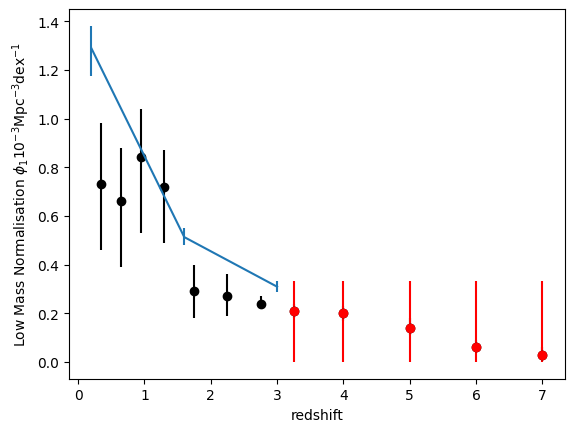

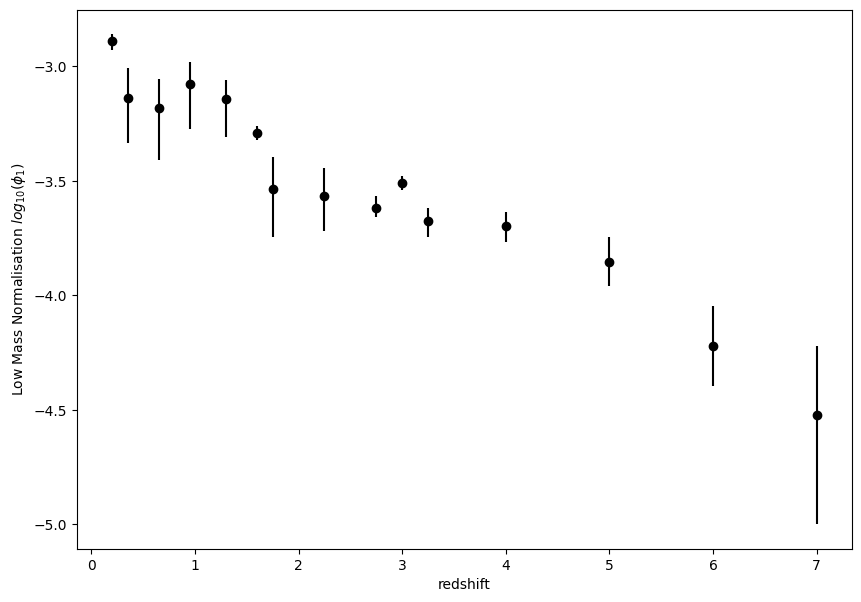

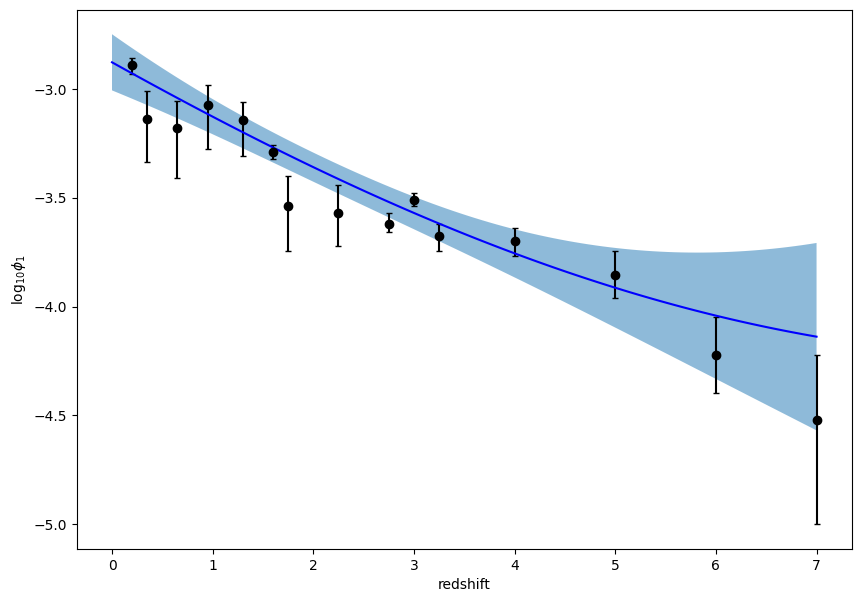

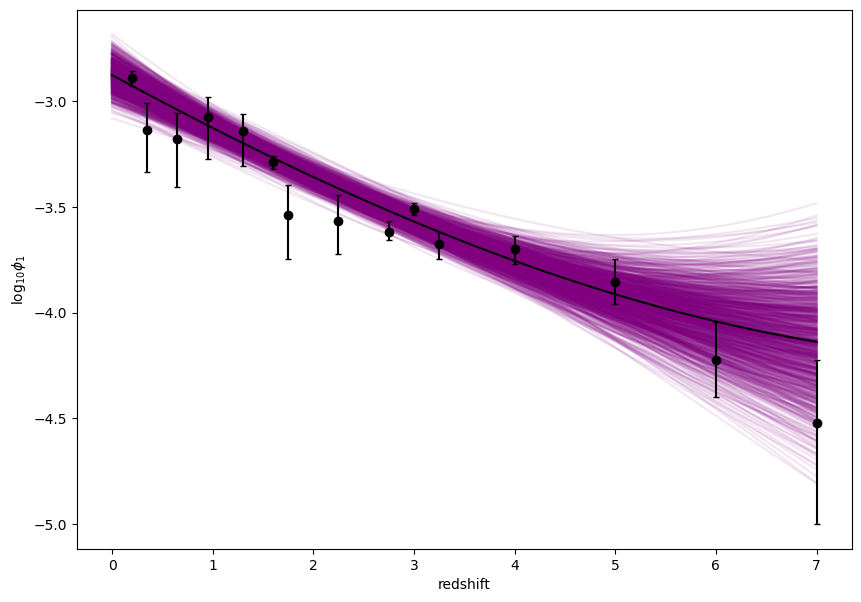

In [5]:
sorted_train_redshift, sorted_train_logphi1, sorted_train_logphi1_errl, sorted_train_logphi1_errh, sorted_train_logphi1_errs = get_phi1_data(plotting=True)
gp(sorted_train_redshift, sorted_train_logphi1, sorted_train_logphi1_errl, sorted_train_logphi1_errh, sorted_train_logphi1_errs, torch.linspace(0, 7, 100), lengthscale=0.0, lr=1e-3, training_iter=20000, ylabel="$\mathrm{log}_{10}\phi_{1}$", name="phi1")


Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
2.7351232885607732
2.73263658713722
2.7301533598227894
2.727674061879492
2.725198195560111
2.72272595385896
2.7202573320670687
2.7177925853200864
2.7153315778317397
2.712874595890894
2.7104215032902124
2.7079721321480807
2.705527057200411
2.703085980384446
2.7006488947803486
2.698216370303444
2.6957875332348653
2.6933632403261294
2.690943099549552
2.688527133842406
2.6861155901147002
2.683708395014858
2.681305729643126
2.678907520289096
2.6765133795019986
2.674123865850893
2.6717389370346734
2.6693583005824473
2.666982417065645
2.6646109626449634
2.662244208080411
2.6598818622532767
2.657523915557703
2.6551707922948213
2.652822325776656
2.650478227111099
2.6481390414602846
2.645804202688707
2.6434741312372716
2.6411486620627915
2.6388277842932752
2.6365116091500336
2.63420003390919
2.631893138718586
2.629590790800359
2.6272931310288525
2.62500011

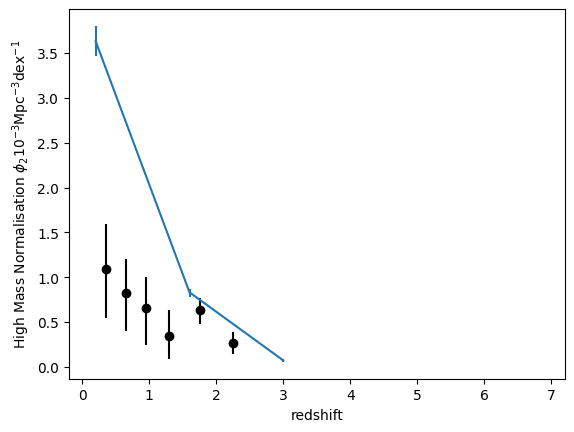

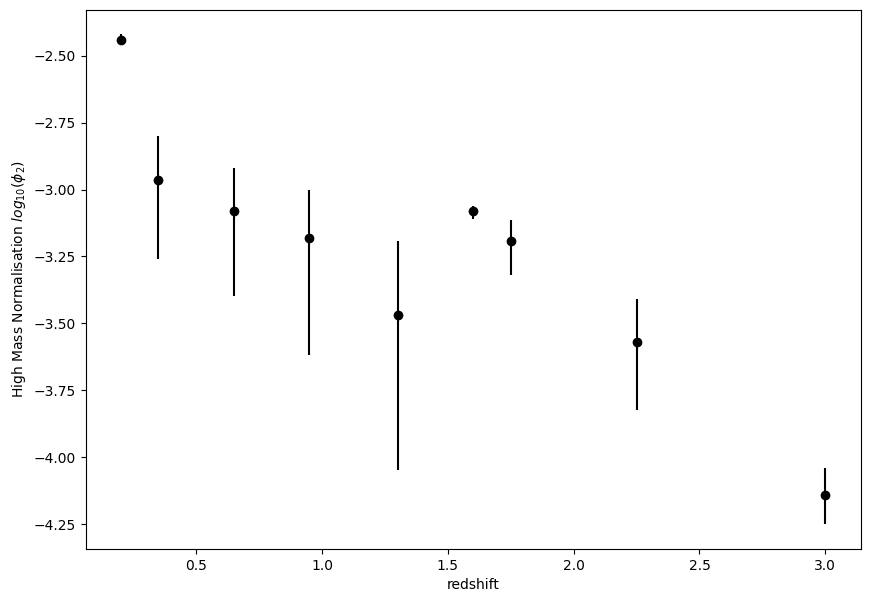

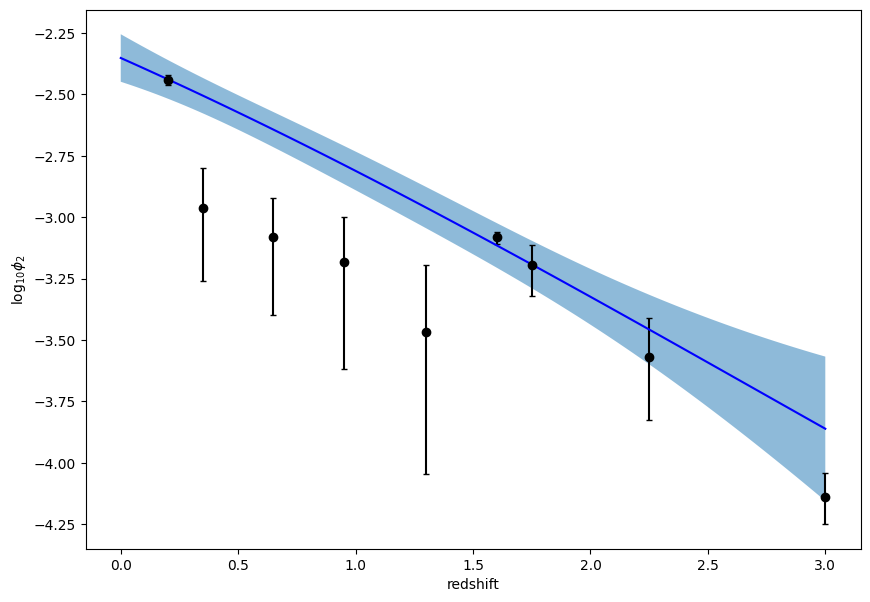

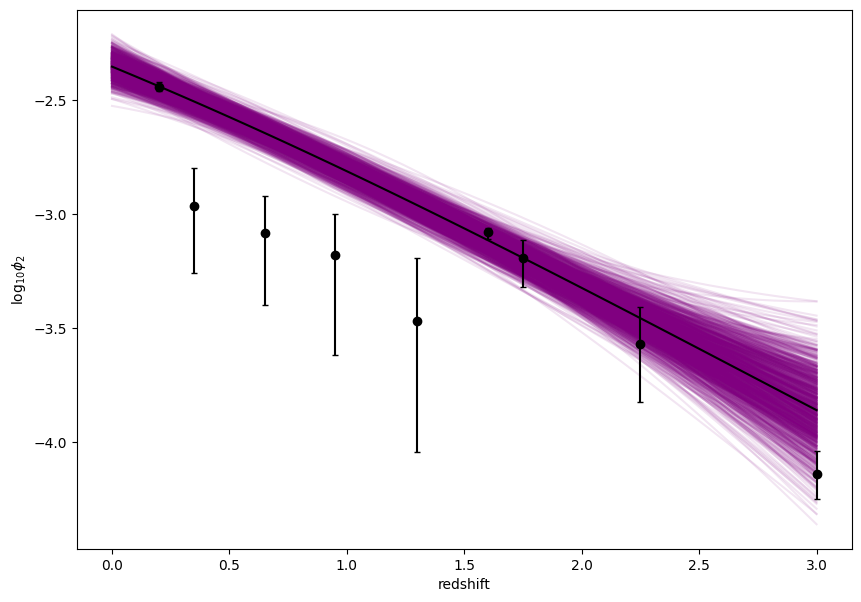

In [6]:
sorted_train_redshift, sorted_train_logphi2, sorted_train_logphi2_errl, sorted_train_logphi2_errh, sorted_train_logphi2_errs = get_phi2_data(plotting=True)
gp(sorted_train_redshift, sorted_train_logphi2, sorted_train_logphi2_errl, sorted_train_logphi2_errh, sorted_train_logphi2_errs, torch.linspace(0, 3, 100), lengthscale=0.0, lr=1e-3, training_iter=20000, ylabel="$\mathrm{log}_{10}\phi_{2}$", name="phi2")


Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
0.334847640966266
0.3341956999097986
0.33354475174023296
0.33289484664681
0.3322460090226673
0.3315981601904514
0.3309512989356988
0.33030551354853027
0.3296609170375144
0.32901732877294954
0.32837487441873353
0.32773348840981953
0.3270932575277692
0.32645423005743673
0.3258163277829491
0.32517957360554484
0.324544040535903
0.3239097009198827
0.3232765143555361
0.3226445533099873
0.32201384034320135
0.3213843594386213
0.3207560086527112
0.32012899638374026
0.31950319515970615
0.31887873801725036
0.31825542396660134
0.31763343543586764
0.3170126458686332
0.31639324872387675
0.3157750681343654
0.3151581503425567
0.3145425412956556
0.3139282003116374
0.3133152339742359
0.3127034679318325
0.3120930205192541
0.3114838881138472
0.3108759832434336
0.3102694585189514
0.3096642496972673
0.3090602813664036
0.3084575386934275
0.30785620977835865
0.307256134

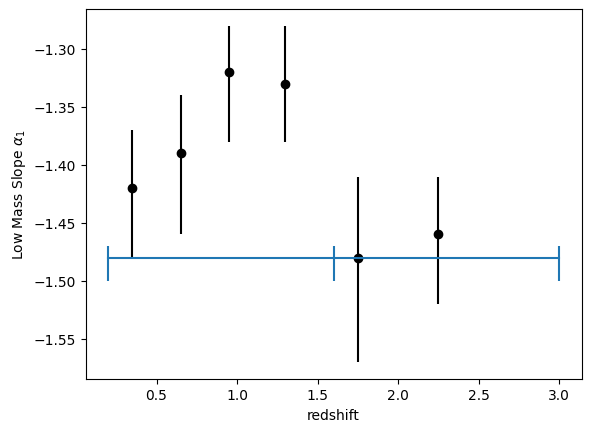

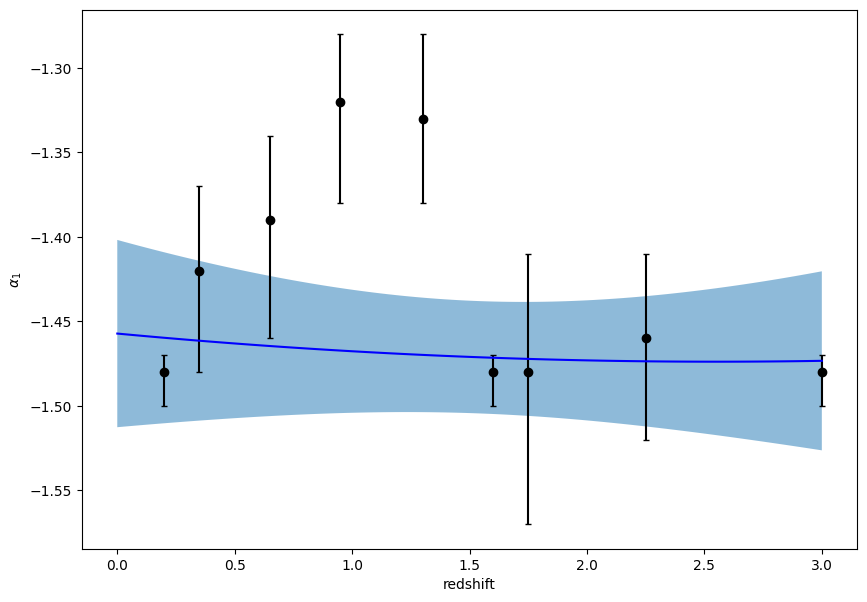

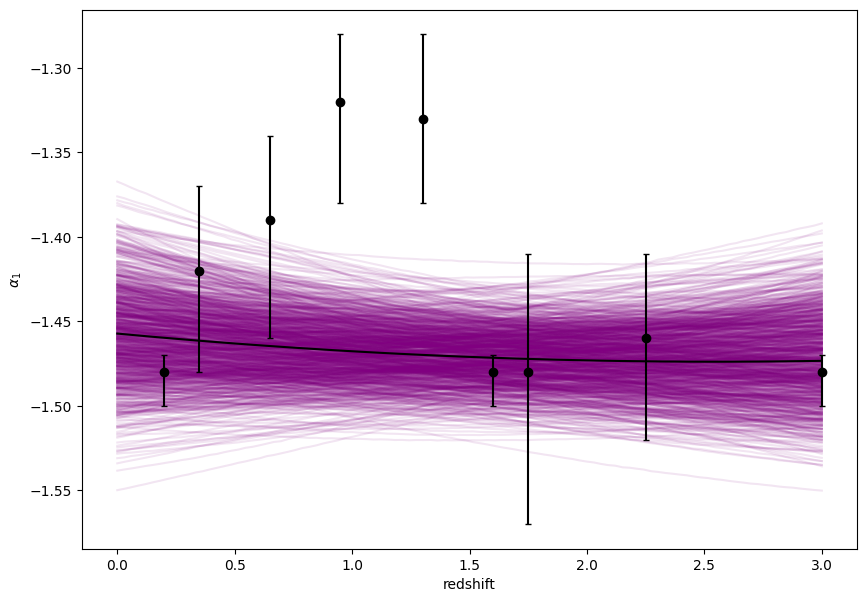

In [7]:
sorted_train_redshift, sorted_train_alpha1, sorted_train_alpha1_errl, sorted_train_alpha1_errh, sorted_train_alpha1_errs = get_alpha1_data(plotting=True)
gp(sorted_train_redshift, sorted_train_alpha1, sorted_train_alpha1_errl, sorted_train_alpha1_errh, sorted_train_alpha1_errs, torch.linspace(0, 3, 100), lengthscale=0.0, lr=1e-3, training_iter=20000, ylabel="$\\alpha_{1}$", name="alpha1")

Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
0.9068856887459555
0.9066824945451244
0.9064793888333165
0.9062763661124743
0.9060734317359448
0.9058705466167495
0.9056677590783322
0.9054650448458763
0.9052624373499918
0.9050598936596388
0.904857432344289
0.9046550774537968
0.9044527861383919
0.9042506159206476
0.9040485220519664
0.9038465156354974
0.9036445909595222
0.9034427720348772
0.9032410587307267
0.9030394175943535
0.9028378818482327
0.9026364272592856
0.9024351019017449
0.9022338574465353
0.9020327029327819
0.9018316531439245
0.9016306988103503
0.9014298340100451
0.9012290735399792
0.9010284172639539
0.9008278741380534
0.9006274258292701
0.9004270754071881
0.9002268285989887
0.90002668526633
0.8998266302873316
0.8996266875258959
0.8994268387717279
0.8992271109441994
0.8990274768435322
0.8988279393289171
0.8986285042480942
0.8984291714594621
0.8982299587371254
0.8980308390338632
0.8978

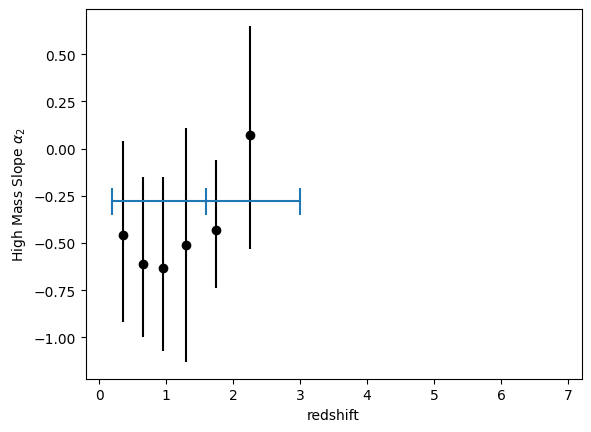

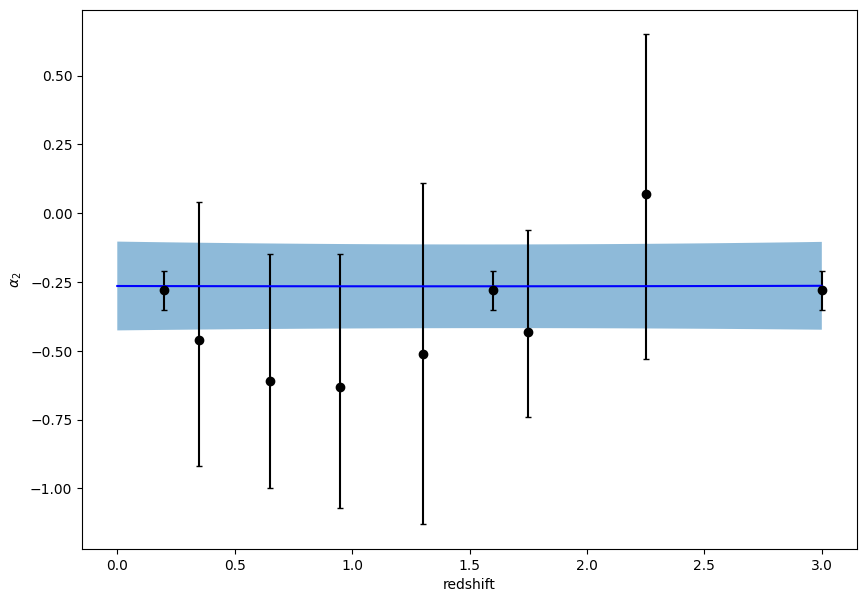

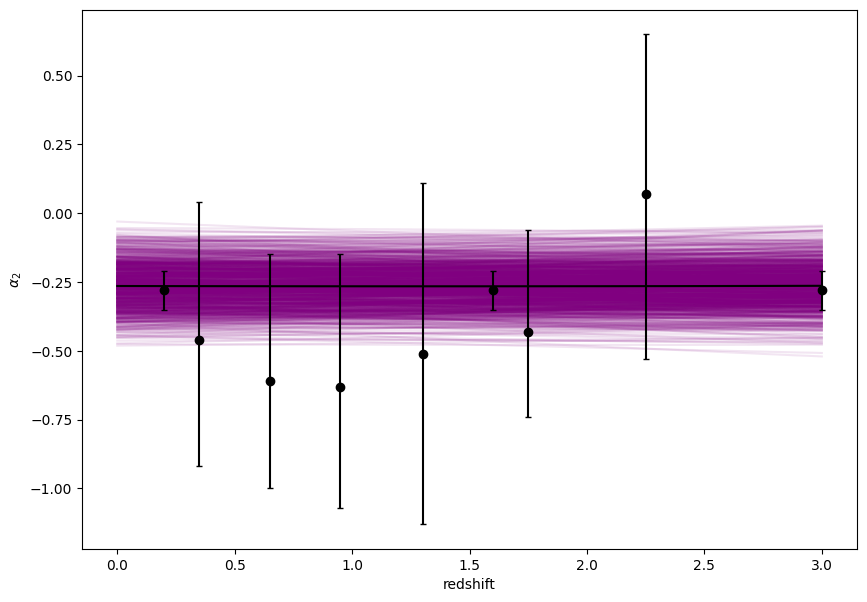

In [8]:
sorted_train_redshift, sorted_train_alpha2, sorted_train_alpha2_errl, sorted_train_alpha2_errh, sorted_train_alpha2_errs = get_alpha2_data(plotting=True)
gp(sorted_train_redshift, sorted_train_alpha2, sorted_train_alpha2_errl, sorted_train_alpha2_errh, sorted_train_alpha2_errs, torch.linspace(0, 3, 100), lengthscale=0.0, lr=1e-3, training_iter=20000, ylabel="$\\alpha_{2}$", name="alpha2")

Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
24.772069197622116
24.740833868163705
24.709645540142223
24.678511544092483
24.64742066827438
24.616380236212386
24.585390148793827
24.554450307124593
24.523564280125317
24.49273194760242
24.46194953655863
24.43121864160073
24.40054669277823
24.369927960820974
24.339362327135905
24.3088569079544
24.278402388041794
24.248006125256317
24.21766963898233
24.187387258144238
24.157166276640773
24.126999119274355
24.096896619542672
24.066847650473484
24.036861099374995
24.006935142780343
23.977065820290175
23.947258414015288
23.917511111933287
23.887823496689013
23.858197287268624
23.82863231016001
23.79912676854047
23.7696834907518
23.740301179304595
23.710979412274007
23.681718019217445
23.652520295202574
23.623382592674986
23.594306344987228
23.56529002321505
23.536334560882665
23.507443953724476
23.478612251816397
23.44984112290496
23.42113063784619

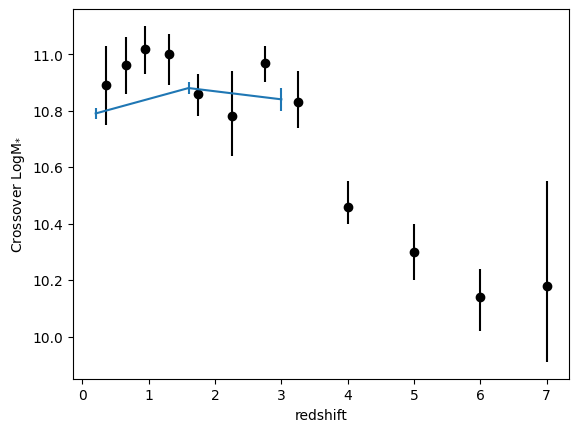

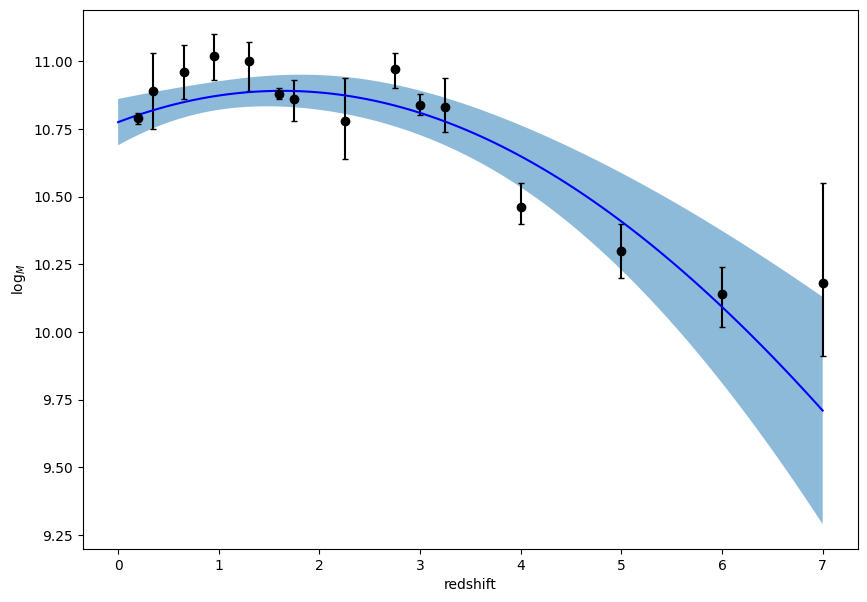

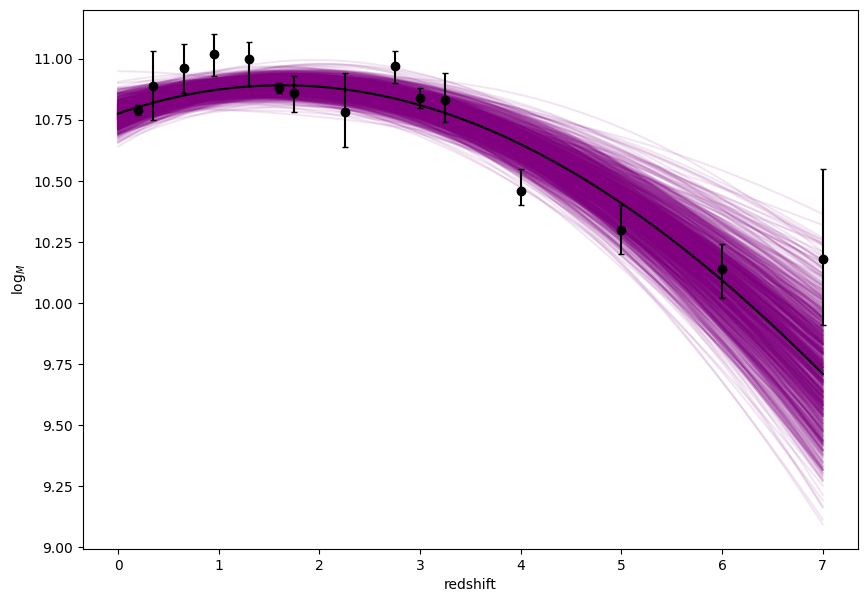

In [9]:
sorted_train_redshift, sorted_train_logm, sorted_train_logm_errl, sorted_train_logm_errh, sorted_train_logm_errs = get_logm_data(plotting=True)
gp(sorted_train_redshift, sorted_train_logm, sorted_train_logm_errl, sorted_train_logm_errh, sorted_train_logm_errs, torch.linspace(0, 7, 100), lengthscale=0.0, lr=1e-3, training_iter=20000, ylabel="$\mathrm{log}_{M}$", name="logm")